In [ ]:
import kagglehub
andrewmvd_hard_hat_detection_path = kagglehub.dataset_download('andrewmvd/hard-hat-detection')

print('Data source import complete.')


Using Colab cache for faster access to the 'hard-hat-detection' dataset.
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/kaggle/input/hard-hat-detection/images/hard_hat_workers4991.png
/kaggle/input/hard-hat-detection/images/hard_hat_workers3833.png
/kaggle/input/hard-hat-detection/images/hard_hat_workers1675.png
/kaggle/input/hard-hat-detection/images/hard_hat_workers4122.png
/kaggle/input/hard-hat-detection/images/hard_hat_workers4460.png
/kaggle/input/hard-hat-detection/images/hard_hat_workers3140.png
/kaggle/input/hard-hat-detection/images/hard_hat_workers4227.png
/kaggle/input/hard-hat-detection/images/hard_hat_workers2646.png
/kaggle/input/hard-hat-detection/images/hard_hat_workers3416.png
/kaggle/input/hard-hat-detection/images/hard_hat_workers1937.png
/kaggle/input/hard-hat-detection/images/hard_hat_workers938.png
/kaggle/input/hard-hat-detection/images/hard_hat_workers4158.png
/kaggle/input/hard-hat-detection/images/hard_hat_workers3363.png
/kaggle/input/hard-hat-detection/images/hard_hat_workers2312.png
/kaggle/input/hard-hat-detection/images/

In [ ]:
# Import libraries
import xml.etree.ElementTree as ET
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil
import cv2
from matplotlib import pyplot as plt
from collections import Counter

In [ ]:
# Setup
INPUT = Path('raw_data')
OUTPUT = Path('PPE_Dataset')
CLASSES = ['helmet', 'head', 'person']

In [ ]:
# Create folders
for split in ['train', 'valid', 'test']:
    (OUTPUT / split / 'images').mkdir(parents=True, exist_ok=True)
    (OUTPUT / split / 'labels').mkdir(parents=True, exist_ok=True)

In [ ]:
# Convert XML to YOLO
def xml_to_yolo(xml_path, w, h):
    tree = ET.parse(xml_path)
    labels = []
    for obj in tree.findall('.//object'):
        cls = obj.find('name').text
        if cls not in CLASSES:
            continue
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)
        x_c = ((xmin + xmax) / 2) / w
        y_c = ((ymin + ymax) / 2) / h
        bw = (xmax - xmin) / w
        bh = (ymax - ymin) / h
        labels.append(f"{CLASSES.index(cls)} {x_c:.6f} {y_c:.6f} {bw:.6f} {bh:.6f}")
    return labels

In [ ]:
# Split dataset
import shutil
import os

source_data_path = Path(andrewmvd_hard_hat_detection_path)
target_data_path = INPUT # This is Path('raw_data')

# Check if target_data_path (raw_data) is already populated with images and annotations
if not (target_data_path / 'images').exists() or not (target_data_path / 'annotations').exists():
    # Create target_data_path if it doesn't exist
    target_data_path.mkdir(parents=True, exist_ok=True)

    # Copy contents (images and annotations folders)
    required_subdirs = ['images', 'annotations']
    for subdir_name in required_subdirs:
        src_subdir = source_data_path / subdir_name
        dst_subdir = target_data_path / subdir_name
        if src_subdir.is_dir():
            if dst_subdir.exists():
                shutil.rmtree(dst_subdir)
            shutil.copytree(src_subdir, dst_subdir)

images = sorted(list((INPUT / 'images').glob('*.png')))
train, temp = train_test_split(images, test_size=0.3, random_state=42)
valid, test = train_test_split(temp, test_size=0.5, random_state=42)
splits = {'train': train, 'valid': valid, 'test': test}

In [ ]:
# Process files
for split, imgs in splits.items():
    for img_path in imgs:
        xml_path = INPUT / 'annotations' / f"{img_path.stem}.xml"
        if not xml_path.exists():
            continue
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        h, w = img.shape[:2]
        labels = xml_to_yolo(xml_path, w, h)
        if not labels:
            continue
        shutil.copy(img_path, OUTPUT / split / 'images' / img_path.name)
        (OUTPUT / split / 'labels' / f"{img_path.stem}.txt").write_text('\n'.join(labels))

In [ ]:
# Create config
yaml = f"""path: /content/PPE_Dataset
train: train/images
val: valid/images
test: test/images
names:
  0: helmet
  1: head
  2: person
"""
Path('data.yaml').write_text(yaml)

124

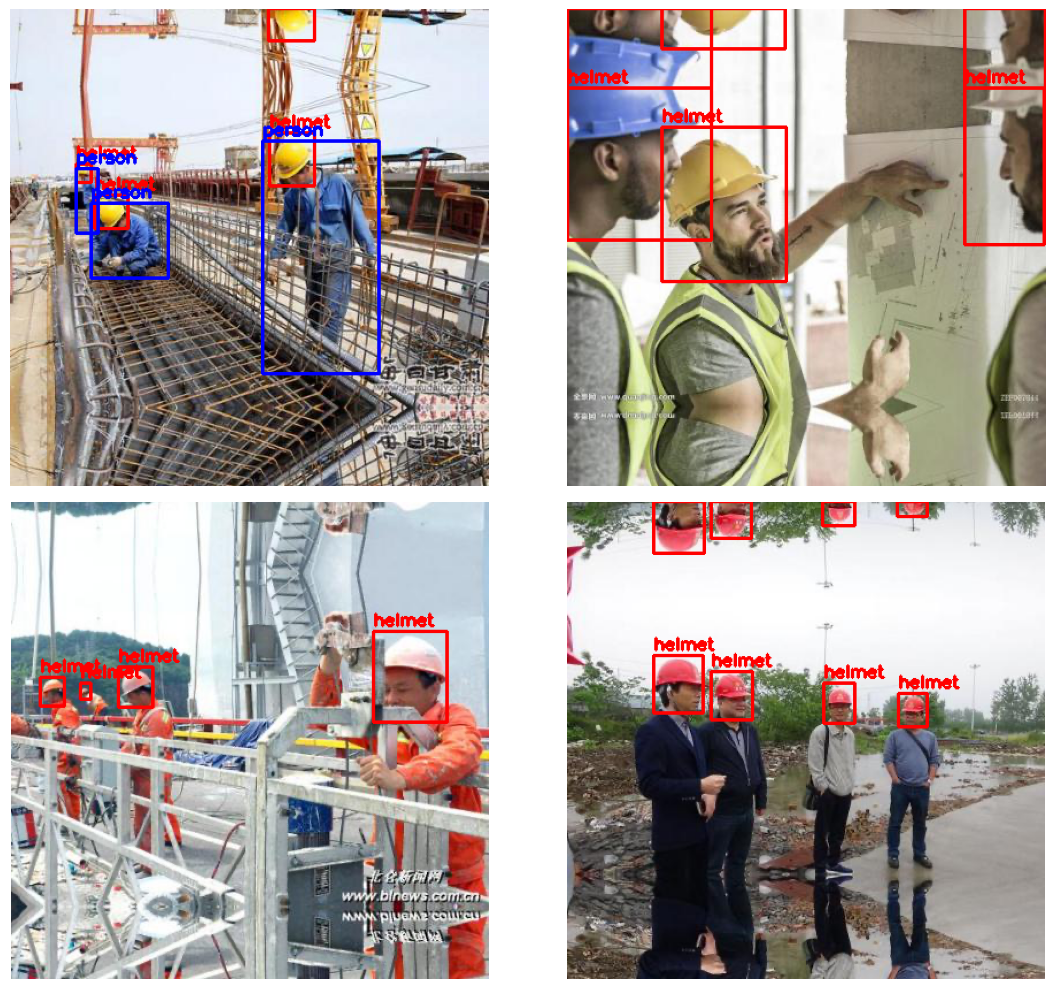

In [ ]:
# Visualize
def draw_boxes(img_path, label_path):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    with open(label_path) as f:
        for line in f:
            c, xc, yc, bw, bh = map(float, line.split())
            x1 = int((xc - bw/2) * w)
            y1 = int((yc - bh/2) * h)
            x2 = int((xc + bw/2) * w)
            y2 = int((yc + bh/2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), colors[int(c)], 2)
            cv2.putText(img, CLASSES[int(c)], (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[int(c)], 2)
    return img

samples = list((OUTPUT / 'train' / 'images').glob('*.png'))[:4]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for idx, img_path in enumerate(samples):
    label_path = OUTPUT / 'train' / 'labels' / f"{img_path.stem}.txt"
    axes[idx//2, idx%2].imshow(draw_boxes(img_path, label_path))
    axes[idx//2, idx%2].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Stats
def count_objects(labels_dir):
    counts = Counter()
    for f in Path(labels_dir).glob('*.txt'):
        for line in f.read_text().split('\n'):
            if line.strip():
                counts[int(line.split()[0])] += 1
    return counts

train_counts = count_objects(OUTPUT / 'train' / 'labels')
print("\nClass Distribution:")
for i, cnt in sorted(train_counts.items()):
    print(f"{CLASSES[i]}: {cnt}")

print(f"\nTrain: {len(list((OUTPUT/'train'/'images').glob('*')))}")
print(f"Valid: {len(list((OUTPUT/'valid'/'images').glob('*')))}")
print(f"Test: {len(list((OUTPUT/'test'/'images').glob('*')))}")
print("\nDataset ready at: /content/PPE_Dataset/")
print("Config file: /content/data.yaml")


Class Distribution:
helmet: 13502
head: 3929
person: 487

Train: 3500
Valid: 750
Test: 750

Dataset ready at: /content/PPE_Dataset/
Config file: /content/data.yaml
